## Implementation of the Vanilla Policy Gradient (REINFORCE) 
### using the Cartpole environment provided by gym

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
from torch import nn
from torch import optim

In [12]:
# create a policy network that input (obs) --> output (logits of actions, logits due to use of softmax function)

class policy_network():
    def __init__(self, env):
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 40), #fully connected layer
            nn.ReLU(), 
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, self.n_outputs),
            nn.Softmax(dim=-1)) # turns logits into probs
    
    def predict(self, obs):
        action_probs = self.network(torch.FloatTensor(obs))
        return action_probs

In [13]:
# create data loop --> save current obs 
#                  --> run obs through policy network get logits of actions
#                  --> sample action using prob_actions from policy network 
#                  --> save action 
#                  --> act using gym env, returns new obs and reward
#                  --> save reward 
#             --> after 1 episode ends save discounted rewards used for optimization
#             --> reset env

def create_episode(policy_network, env): # done
    action_space = np.arange(env.action_space.n)
    done = False
    obs = env.reset()
    observations, rewards, actions = [], [], []
    while not done:
        observations.append(obs)
        act_probs = policy_network.predict(obs).detach().numpy() 
        act = np.random.choice(action_space, p=act_probs) 
        actions.append(act)
        obs, r, done, _ = env.step(act)
        rewards.append(r)
    return observations, actions, rewards

def normalized_discounted_rewards(rewards, gamma): # done
    r = np.array([gamma**i * rewards[i] for i in range(len(rewards))])
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

def create_batch(policy_network, batch_size, env, gamma): # done
    batch_discrew, batch_obs, batch_acts, total_rewards = [],[],[],[]
    for ep in range(batch_size):
        observations, actions, rewards = create_episode(policy_network, env)
        batch_discrew.extend(normalized_discounted_rewards(rewards, gamma))
        batch_obs.extend(observations)
        batch_acts.extend(actions)
        total_rewards.append(sum(rewards))
    avg_return = np.mean(total_rewards)
    #print("Created a batch")
    return batch_discrew, batch_obs, batch_acts, avg_return


# optimize policy parameters --> calculate loss:
#                                       --> sum of gradients of policy gradient for all actions in an episode
#                                           --> arguments should contain all episodes (in a tensor for example)
#                                           --> sum(actions * softmax(logits)), use softmax to transform logits to probs
#                                       --> weight the sum by discounted rewards (discounted rewards is acting as A)
#                                       --> loss =  -average of previous result
#                            --> calculate gradients of each layer: use the loss to backpropogate and obtain the gradients
#                            --> update weights of each layer


def VPG_loss(policy_net, obs_tensor, reward_tensor, action_tensor):
    # calculate loss
    logprobs = torch.log(policy_net.predict(obs_tensor))
    logprobs_a = torch.gather(logprobs, 1, action_tensor.view(-1,1)).squeeze()
    logprobs_b = reward_tensor * logprobs_a 
    loss = -logprobs_b.mean()
    return loss


In [17]:
def rl(env, policy_net, num_epochs, batch_size, gamma, loss_type, optimizer_type):
    avg_returns = []
    
    epoch = 0
    # Define optimizer
    if optimizer_type == "Adam":
        optimizer = optim.Adam(policy_net.network.parameters(), lr=0.01) 
    
    action_space = np.arange(env.action_space.n)
    
    while epoch < num_epochs:
        #create a batch
        batch_discrew, batch_obs, batch_acts, avg_return = create_batch(policy_net, batch_size, env, gamma)
        avg_returns.append(avg_return)
        print("\rEpoch:"+" {:.2f}".format(epoch+1)+" Average reward of batch:" + "{:.2f}".format(avg_return), end="")
        optimizer.zero_grad()
        
        #convert to tensors
        obs_tensor = torch.FloatTensor(batch_obs)
        reward_tensor = torch.FloatTensor(batch_discrew)
        action_tensor = torch.LongTensor(batch_acts)
        
        #calculate loss and update parameters of policy network
        if loss_type == "VPG":
            logprobs = torch.log(policy_net.predict(obs_tensor))
            logprobs1= reward_tensor * torch.gather(logprobs, 1, action_tensor.view(-1,1)).squeeze() # does the sum over grads
            loss = -logprobs1.mean()
            loss.backward()
            optimizer.step()
        
        
        epoch += 1
    
    
    return avg_returns

In [22]:
def main():
    env = gym.make('CartPole-v0')
    avg_returns = rl(env, policy_network(env), num_epochs=40, batch_size=20, 
                     gamma=0.99, loss_type = "VPG", optimizer_type = "Adam")
    return avg_returns

Epoch: 40.00 Average reward of batch:200.00

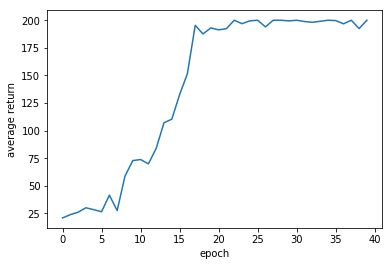

In [23]:
plt.plot(main())
plt.ylabel("average return")
plt.xlabel("epoch")
plt.show()